# Lesson 4: CNN from scratch
- Video >> https://www.youtube.com/watch?v=H3g26EVADgY&t=4377s
- wiki >> http://forums.fast.ai/t/wiki-lesson-7/9405
- Lesson notes >> https://medium.com/@hiromi_suenaga/deep-learning-2-part-1-lesson-7-1b9503aff0c

The objective of this lesson is to dig deeper into a CNN. We saw up to now different building blocks like a convolution, ReLu, DropOut... Let's design ourself from scratch our own CNN and understand why it works like this and how to improve!

In [1]:
! pip install --upgrade git+https://github.com/keras-team/keras.git \
                        git+https://github.com/valeoai/dl_utils.git \
                        imageio

  Cloning https://github.com/keras-team/keras.git to /tmp/pip-req-build-o1nllriq
  Cloning https://github.com/valeoai/dl_utils.git to /tmp/pip-req-build-t2pno3wt
    100% |████████████████████████████████| 3.3MB 1.4MB/s 
  Running setup.py bdist_wheel for imageio ... - \ | / done
  Stored in directory: /root/.cache/pip/wheels/e0/43/31/605de9372ceaf657f152d3d5e82f42cf265d81db8bbe63cde1
  Running setup.py bdist_wheel for Keras ... - \ done
  Stored in directory: /tmp/pip-ephem-wheel-cache-5uqzqwcp/wheels/da/a4/7e/6b7bd9af18cc2e23b8dd5ed6de07a7e13bd80a17214eb88932
  Running setup.py bdist_wheel for dl-utils ... - done
  Stored in directory: /tmp/pip-ephem-wheel-cache-5uqzqwcp/wheels/71/ad/e4/ef0ed3b20fc1828e7eb4b7fddc4342ae6a7672d62fa2b89c6a
Successfully built imageio Keras dl-utils
  Found existing installation: Keras 2.2.4
    Uninstalling Keras-2.2.4:
      Successfully uninstalled Keras-2.2.4


## CIFAR 10

In [2]:
# standard lib we need!
import os
from pathlib import Path # lib to handle filesystem paths with semantics appropriate for different OS
import matplotlib.pyplot as plt # Matplotlib is a plotting library for the Python but it has also some IO functions
import numpy as np 
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras import optimizers
from dlutils import LRFinder
from dlutils import SGDRScheduler

Using TensorFlow backend.


CIFAR10 Dataset is already included in Keras.datasets, you just need to import it, quite easy!

In [3]:
from keras.datasets import cifar10

# The data, split between train and test sets:
(X_train, Y_train), (X_test, Y_test) = cifar10.load_data()
X_CIFAR = X_test
Y_CIFAR = Y_test
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

170500096/170498071 [==============================] - 16s 0us/step
X_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


### Look at the data

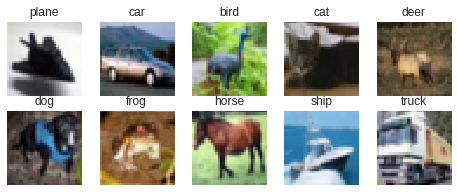

In [4]:
nb_classes = 10
class_names = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

fig = plt.figure(figsize=(8,3))
for i in range(nb_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(Y_train[:]==i)[0]
    im = X_train[idx[0]]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

## Fully connected model

In [0]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten

def SimpleNet():
    model = Sequential()
    model.add(Dense(40, input_shape=(32*32*3,)))
    model.add(Dense(10))
    model.add(Activation('softmax'))
    
    return model

In [6]:
net = SimpleNet()
net.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 40)                122920    
_________________________________________________________________
dense_2 (Dense)              (None, 10)                410       
_________________________________________________________________
activation_1 (Activation)    (None, 10)                0         
Total params: 123,330
Trainable params: 123,330
Non-trainable params: 0
_________________________________________________________________


In [0]:
# we prepare the data to fit with the expected model format: an image is a vector of pixels and some basic preprocessng
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255.0
X_test /= 255.0

X_train_L = X_train.reshape(50000, 32 * 32 * 3)
X_test_L = X_test.reshape(10000, 32 * 32 * 3)

# instead of providing a 1D vector where a label is a scalar between 0 to nb_classes
# we have to provide a vector per label of size nb_classes where only 1 class is activated (9 zeros and only one 1)
Y_train = keras.utils.to_categorical(Y_train, nb_classes)
Y_test = keras.utils.to_categorical(Y_test, nb_classes)

Epoch 1/1
50000/50000 [==============================] - 3s 51us/step - loss: 2.3192 - acc: 0.2318


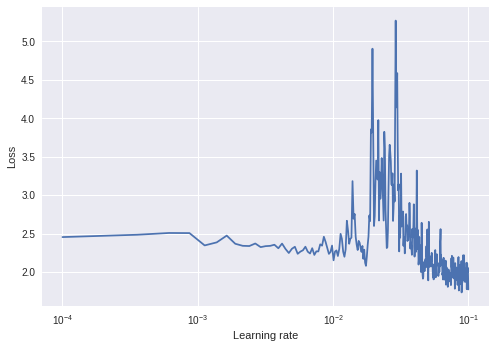

In [8]:
# we launch the learning rate finder
batch_size = 128

net.compile(optimizer='SGD',loss='categorical_crossentropy', metrics=['accuracy'])
# The Loss is categorical_crossentropy as we have more than 2 category!

lr_finder = LRFinder(min_lr=1e-4, 
                     max_lr=1e-1, 
                     steps_per_epoch=len(X_train)//batch_size)

# Fit the model on the batches
net.fit(X_train_L, Y_train,batch_size=batch_size,callbacks=[lr_finder])

lr_finder.plot_loss()

In [9]:
# we define  few parameters
LR = 6e-3
nb_epochs = 10

sgd = optimizers.SGD(lr=LR)
net.compile(optimizer=sgd,loss='categorical_crossentropy', metrics=['accuracy'])
# training
net.fit(X_train_L, Y_train,
          batch_size=batch_size,
          epochs=nb_epochs,
          verbose=1,
          validation_data=(X_test_L, Y_test))

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 2s 39us/step - loss: 1.8421 - acc: 0.3643 - val_loss: 1.8316 - val_acc: 0.3681
Epoch 2/10
50000/50000 [==============================] - 2s 37us/step - loss: 1.8218 - acc: 0.3705 - val_loss: 1.8183 - val_acc: 0.3723
Epoch 3/10
50000/50000 [==============================] - 2s 37us/step - loss: 1.8103 - acc: 0.3751 - val_loss: 1.8083 - val_acc: 0.3765
Epoch 4/10
50000/50000 [==============================] - 2s 37us/step - loss: 1.8009 - acc: 0.3774 - val_loss: 1.7985 - val_acc: 0.3768
Epoch 5/10
50000/50000 [==============================] - 2s 37us/step - loss: 1.7934 - acc: 0.3798 - val_loss: 1.7933 - val_acc: 0.3757
Epoch 6/10
50000/50000 [==============================] - 2s 37us/step - loss: 1.7869 - acc: 0.3814 - val_loss: 1.7886 - val_acc: 0.3813
Epoch 7/10
50000/50000 [==============================] - 2s 37us/step - loss: 1.7809 - acc: 0.3846 - val_loss: 1.7886 - val_acc

<b>Results is pretty bad, we obtained about 40% of accuracy on the test set</b>

Actually, it is not a suprised. Indeed, this architecture is pretty inefficient, each pixel has its own weight, resulting to a huge number of parameters, about 100k parameters (32.32.3*40). It is actually a dot product. We are missing some kind of feature extraction --> let's use Convolution for that

## Convolutional Model
Let's do it a bit deeper and use 2D convolutions.
We will start with a standard pattern using a sequence of <b>convolutions >> ReLu >> MaxPooling</b> and finally ending by a fully connected layer and a SoftMax activation (see [here](http://cs231n.github.io/convolutional-networks/#layerpat) for common architecture).

<img src="https://raw.githubusercontent.com/valeoai/tutorial-images/master/images/04_advanced_CNN/CNN_archi.png" width="80%">

Remember:
- Convolution acts like a feature extractor (Linear operation) (see [here](http://cs231n.github.io/convolutional-networks/#conv) for details)
- ReLu in a non linear transformation which gives the ability to build complex shapes
<img src="https://raw.githubusercontent.com/valeoai/tutorial-images/master/images/04_advanced_CNNCNN_archi.png" width="80%">
- MaxPooling is mainly used to reduce the number of parameters, that is to say memory and computation constraints ([here](http://cs231n.github.io/convolutional-networks/#pool) for details) <img src="https://raw.githubusercontent.com/valeoai/tutorial-images/master/images//MaxPooling.jpeg" width="50%">
We can either specify how big is the area to use <kbd>MaxPooling2D</kbd> or how big is the output resolution <kbd>GlobalAveragePooling2D</kbd>
- Fully Connected Layer, each neuron has full connections to all activations in the previous layer
- SoftMax is an activation layer to classify. If we want to predict a value rather than classifying, then we should suppress the SOftMax Layer

In [0]:
from keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D

def CNNnet():
    model = Sequential()
    model.add(Conv2D(32, (5, 5), padding='same',input_shape=X_train.shape[1:]))
    model.add(Activation('relu'))
   
    model.add(Conv2D(32, (3, 3),padding='same',strides=1))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))
    
    model.add(Conv2D(64, (3, 3),padding='same'))
    model.add(Activation('relu'))
    
    model.add(GlobalAveragePooling2D())
               
    model.add(Dense(nb_classes))
    model.add(Activation('softmax'))    
    return model 

<b>Trick:</b> first layer usually uses bigger conv size compared to the rest of the network to extract more rich information than the image itself.

In [11]:
net2 = CNNnet()
net2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        2432      
_________________________________________________________________
activation_2 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_3 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
activation_4 (Activation)    (None, 16, 16, 64)        0         
__________

Epoch 1/1
50000/50000 [==============================] - 299s 6ms/step - loss: 2.2464 - acc: 0.1425


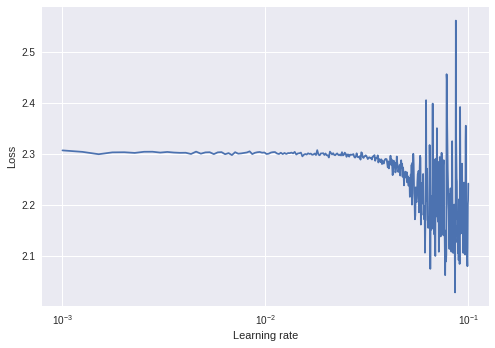

In [12]:
# As usual, as we don t know which learning rate to use, we then start with a learning rate finder
batch_size = 128

net2.compile(optimizer='SGD',loss='categorical_crossentropy', metrics=['accuracy'])
# The Loss is categorical_crossentropy as we have more than 2 category!

lr_finder = LRFinder(min_lr=1e-3, 
                     max_lr=1e-1, 
                     steps_per_epoch=len(X_train)//batch_size)

# Fit the model on the batches
net2.fit(X_train, Y_train,batch_size=batch_size, callbacks=[lr_finder])

lr_finder.plot_loss()

In [0]:
# we define  few parameters
sgd = optimizers.SGD(lr=2e-2)
net2.compile(optimizer=sgd,loss='categorical_crossentropy', metrics=['accuracy'])

sgdr = SGDRScheduler(min_lr=1e-3,
                     max_lr=1e-1,
                     steps_per_epoch=len(X_train)//batch_size,
                     lr_decay=0.8,
                     number_of_cycle = 3,
                     cycle_length=15,
                     cycle_mult_factor=1.5)

In [0]:
history = net2.fit(X_train, Y_train, batch_size=batch_size, epochs=sgdr.nb_epoch,
                   validation_data=(X_test, Y_test),
                   verbose=1,
                   callbacks=[sgdr])

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(sgdr.history['lr'])
plt.title('Learning rate')
plt.ylabel('LR')
plt.xlabel('Epoch')
plt.show()

Train on 50000 samples, validate on 10000 samples
Epoch 1/71
50000/50000 [==============================] - 312s 6ms/step - loss: 2.0839 - acc: 0.2116 - val_loss: 2.0171 - val_acc: 0.2270
Epoch 2/71
50000/50000 [==============================] - 310s 6ms/step - loss: 1.9404 - acc: 0.2702 - val_loss: 2.0418 - val_acc: 0.2556
Epoch 3/71
50000/50000 [==============================] - 312s 6ms/step - loss: 1.8455 - acc: 0.3078 - val_loss: 1.8210 - val_acc: 0.2823
Epoch 4/71
50000/50000 [==============================] - 310s 6ms/step - loss: 1.7407 - acc: 0.3518 - val_loss: 1.6684 - val_acc: 0.3891
Epoch 5/71
50000/50000 [==============================] - 311s 6ms/step - loss: 1.6544 - acc: 0.3904 - val_loss: 1.6109 - val_acc: 0.4033
Epoch 6/71
50000/50000 [==============================] - 314s 6ms/step - loss: 1.5870 - acc: 0.4190 - val_loss: 1.5455 - val_acc: 0.4277
Epoch 7/71
50000/50000 [==============================] - 313s 6ms/step - loss: 1.5189 - acc: 0.4475 - val_loss: 1.4549 - 

We reach about 69% of accuracy on validation set for only 67k parameters!

We can run for more epochs but we will overfit soon.

Actually, it is not an issue of number of example as we have already 50k samples, but rather an issue of model complexity: our model is too simple!

## BatchNorm

Normalize the activations of the previous layer at each batch, i.e. applies a transformation that maintains the mean activation close to 0 and the activation standard deviation close to 1.

[link](https://towardsdatascience.com/batch-normalization-in-neural-networks-1ac91516821c)
[link](https://www.learnopencv.com/batch-normalization-in-deep-networks/)


it suppresses Mean & STD of the weights and then add an added value + scale factor as new hyper parameter

In [0]:
from keras.layers import BatchNormalization

def CNN_BN():
    model = Sequential()
    model.add(Conv2D(32, (5, 5), padding='same',input_shape=X_train.shape[1:]))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
   
    model.add(Conv2D(32, (3, 3),padding='same',strides=1))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    
    model.add(Conv2D(64, (3, 3),padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())

    model.add(GlobalAveragePooling2D())
               
    model.add(Dense(nb_classes))
    model.add(Activation('softmax'))    
    return model 

In [0]:
net3 = CNN_BN()
net3.summary()

In [0]:
# we define  few parameters
sgd = optimizers.SGD(lr=2e-1)
net3.compile(optimizer=sgd,loss='categorical_crossentropy', metrics=['accuracy'])

sgdr = SGDRScheduler(min_lr=1e-4,
                     max_lr=1e-1,
                     steps_per_epoch=len(X_train)//batch_size,
                     lr_decay=0.8,
                     number_of_cycle = 3,
                     cycle_length=15,
                     cycle_mult_factor=2)

# we defined a cycle length of 10 epoch, so if we want 3 restart, we should then put 30 epochs
history = net3.fit(X_train, Y_train, batch_size=batch_size, epochs=sgdr.nb_epoch,
                   validation_data=(X_test, Y_test),
                   verbose=1,
                   callbacks=[sgdr])

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Not bad, 77% of accuracy using BatchNorm and we overfit!
so, it s time to use some dropout ;-)

## DropOut


Remember, in one of our previous course, we introduced two ways to reduce overfitting:
- more data, using Data Augmentation
- Regularization: make use of Dropout


<b>DropOut</b> is a technique where randomly selected neurons are ignored during training. They are “dropped-out” randomly. This means that their contribution to the activation of downstream neurons is temporally removed on the forward pass and any weight updates are not applied to the neuron on the backward pass. Its parameter is the percentage of neurom dropout.

<img src="https://raw.githubusercontent.com/valeoai/tutorial-images/master/images/04_advanced_CNN/Dropout.png" width="50%">

Further readings [here](https://medium.com/@amarbudhiraja/https-medium-com-amarbudhiraja-learning-less-to-learn-better-dropout-in-deep-machine-learning-74334da4bfc5) and [here](https://machinelearningmastery.com/dropout-regularization-deep-learning-models-keras/)

In [0]:
def CNN_Dropout():    
    
    model = Sequential()
    model.add(Conv2D(32, (5, 5), padding='same',input_shape=X_train.shape[1:]))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    
    model.add(Conv2D(32, (3, 3),padding='same',strides=1))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    
    model.add(Conv2D(64, (3, 3),padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    
    model.add(GlobalAveragePooling2D())
               
    model.add(Dense(nb_classes))
    model.add(Activation('softmax'))    
    return model 

In [0]:
net4 = CNN_Dropout()
net4.summary()

In [0]:
# we define  few parameters
sgd = optimizers.SGD(lr=2e-1)
net4.compile(optimizer=sgd,loss='categorical_crossentropy', metrics=['accuracy'])

sgdr = SGDRScheduler(min_lr=1e-4,
                     max_lr=1e-1,
                     steps_per_epoch=len(X_train)//batch_size,
                     lr_decay=0.8,
                     number_of_cycle = 3,
                     cycle_length=15,
                     cycle_mult_factor=2)

history = net4.fit(X_train, Y_train, batch_size=batch_size, epochs=sgdr.nb_epoch,
                   validation_data=(X_test, Y_test),
                   verbose=1,
                   callbacks=[sgdr])

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Dropout give 4% more of accuracy by discarding randomly few neurons (20%).
We start to overfit after Epoch 70. So we can either add more severe Dropout or provide more data, or both ;-)

Finally, evrything we did is to apply what we learned during the lesson and stack together some layer like LEGO. 

## Refactoring

For the sake of clarity, we are going to refactor what we did. Indeed, the architecture is a sequence of pattern that we can put into a function. So that, it will be much easier to stack convolution on the top of previous layers.

In [0]:
def Conv_block(kernel_size,strides,n_output,MaxPooling,DropOut,BN):
    # kernel_size: size of the convolution kernel
    # strides: stride size
    # n_output: number of feature maps in the block
    # MaxPooling: True or False
    
    def f(input):
        x = Conv2D(kernel_size=kernel_size, filters=n_output, strides=strides, padding='same')(input)
        x = Activation(relu)(x)
        if(BN==True):
            x = BatchNormalization()(x)
        if(MaxPooling==True):
            x = MaxPooling2D(pool_size=(2, 2))(x)
        if(DropOut==True):
            x = Dropout(0.25)(x)

        return x
    
    return f

In [0]:
from keras.layers import Input,GlobalAveragePooling2D
from keras.activations import relu, softmax
from keras.models import Model

def CNN_Refactored():
    input_tensor = Input(X_train.shape[1:])
   
    x = Conv_block(kernel_size=5,strides=1,n_output=32,MaxPooling=False,DropOut=True,BN=True)(input_tensor)
    
    x = Conv_block(kernel_size=3,strides=1,n_output=32,MaxPooling=True,DropOut=True,BN=True)(x)
    
    x = Conv_block(kernel_size=3,strides=1,n_output=64,MaxPooling=False,DropOut=False,BN=False)(x)
    
    x = Conv_block(kernel_size=3,strides=1,n_output=64,MaxPooling=False,DropOut=True,BN=True)(x)
    
    x = GlobalAveragePooling2D()(x)

    x = Dense(nb_classes)(x)
    x = Activation(softmax)(x)
    
    model = Model(inputs=input_tensor, outputs=x)
    return model    

## Resnet

As you might have noticed, since the beginning of the Fast.ai lesson, it uses ResNet model. However, we did not used it up to now because only ResNet50 has pretrained weights available in Keras.

With CIFAR10, it is now the opportunity to try our own tiny version of ResNet as with learn from scratch!

There are [here](https://medium.com/@14prakash/understanding-and-implementing-architectures-of-resnet-and-resnext-for-state-of-the-art-image-cf51669e1624) and [here](https://blog.waya.ai/deep-residual-learning-9610bb62c355) some interesting posts about Residual Network.

<img src="https://raw.githubusercontent.com/valeoai/tutorial-images/master/images/ResNet2.png" width="70%">

The ResNet architecture can be represented as following:
<img src="https://raw.githubusercontent.com/valeoai/tutorial-images/master/images/ResNet_archi.png" width="40%">

In practice, we can't use the identity function everywhere because the addition as to use consistent inputs dimensions. So, when the input x and output F(x) have different dimensions, we have to use special tricks:
- spatial dimension of the Tensor is not the same: it can be reduce either by the convolution stride or a MaxPoolingLayer
- Depth of tensor is not the same: we can use a 2d convolution with 1x1 kernel to replace the identity function. 

Therefore, we have to slightly modify our initial network to comply with this constraint. looking to our previous Tensor size:

| Layer                        |output size               |param  |   
|------------------------------|--------------------------|-------|
| conv2d_49 (Conv2D)           |(None, 32, 32, 32)        |2432   |   
|activation_61 (Activation)    |(None, 32, 32, 32)        | 0     |         
|batch_normalization_4 (Batch  |(None, 32, 32, 32)        |128    |       
|conv2d_50 (Conv2D)            |(None, 32, 32, 32)        |9248   |      
|activation_62 (Activation)    |(None, 32, 32, 32)        |0      |   
|batch_normalization_5 (Batch  |(None, 32, 32, 32)        |128    |   
|max_pooling2d_12 (MaxPooling  |(None, 16, 16, 32)        |0      |   
|conv2d_51 (Conv2D)            |(None, 16, 16, 64)        |18496  |   
|activation_63 (Activation)    |(None, 16, 16, 64)        |0      |   
|conv2d_52 (Conv2D)            |(None, 16, 16, 64)        |36928  |   
|activation_64 (Activation)    |(None, 16, 16, 64)        |0      |   
|batch_normalization_6 (Batch  |(None, 16, 16, 64)        |256    |   
|global_average_pooling2d_12   |(None, 64)                |0      |
|dense_14 (Dense)              |(None, 10)                |650    |

It looks quite simple to make a shortcut between the output of max_pooling2d_12 (16, 16, 32) and the output of batch_normalization_6 (16, 16, 64) --> we just need to upscale the depth of the tensor




In [0]:
from keras.layers.merge import add

#shortcut connection.

def CNN_ResNet():
    input_tensor = Input(X_train.shape[1:])
   
    x = Conv_block(kernel_size=5,strides=1,n_output=32,MaxPooling=False,DropOut=True,BN=True)(input_tensor) # (32, 32, 32)
    
    # Fist block
    x = Conv_block(kernel_size=3,strides=1,n_output=32,MaxPooling=True,DropOut=True,BN=True)(x) #(16, 16, 32)
    
    x = Conv_block(kernel_size=3,strides=1,n_output=64,MaxPooling=False,DropOut=False,BN=False)(x) #(16, 16, 64))
    
    F = Conv_block(kernel_size=3,strides=1,n_output=64,MaxPooling=False,DropOut=True,BN=True)(x) # (16, 16, 64) 
    
    F = Conv_block(kernel_size=1,strides=1,n_output=64,MaxPooling=False,DropOut=False,BN=False)(F) # upscale
    R_1 = add([F, x])
    
    x = GlobalAveragePooling2D()(R_1)

    x = Dense(nb_classes)(x)
    x = Activation(softmax)(x)
    
    model = Model(inputs=input_tensor, outputs=x)
    return model    

In [0]:
net5 = CNN_ResNet()
net5.summary()

In [0]:
# we define  few parameters
sgd = optimizers.SGD(lr=2e-1)
net5.compile(optimizer=sgd,loss='categorical_crossentropy', metrics=['accuracy'])

sgdr = SGDRScheduler(min_lr=1e-4,
                     max_lr=1e-1,
                     steps_per_epoch=len(X_train)//batch_size,
                     lr_decay=0.8,
                     number_of_cycle = 3,
                     cycle_length=15,
                     cycle_mult_factor=2)

history = net5.fit(X_train, Y_train, batch_size=batch_size, epochs=sgdr.nb_epoch,
                   validation_data=(X_test, Y_test),
                   verbose=1,
                   callbacks=[sgdr])

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

We add a slight gain of 2%. It is not amazing but just adding a shortcuts is already good. 
At this stage, we do not overfit. So, if we want to improve our performances, we need a deeper architecture.
And only in a second time if we overfit, then we can use data augmentation

In [0]:
def conv_block2(n_output, upscale=False):
    # n_output: number of feature maps in the block
    # upscale: should we use the 1x1 conv2d mapping for shortcut or not
    
    # keras functional api: return the function of type
    # Tensor -> Tensor
    def f(x):
        
        # H_l(x):
        # first pre-activation
        # first convolution
        h = Conv2D(kernel_size=3, filters=n_output, strides=1, padding='same')(x)
        h = Activation(relu)(h)
        h = BatchNormalization()(h)
        
        # second pre-activation
        # second convolution
        h = Conv2D(kernel_size=3, filters=n_output, strides=1, padding='same')(h)
        h = Activation(relu)(h)        
        h = BatchNormalization()(h)
        
        # f(x):
        if upscale:
            # 1x1 conv2d
            f = Conv2D(kernel_size=1, filters=n_output, strides=1, padding='same')(x)
        else:
            # identity
            f = x
        
        # F_l(x) = f(x) + H_l(x):
        return add([f, h])
    
    return f


def CNN_ResNet_Deeper():
    
    input_tensor = Input(X_train.shape[1:])

    # first conv2d with post-activation to transform the input data to some reasonable form
    x = Conv_block(kernel_size=5,strides=1,n_output=32,MaxPooling=False,DropOut=True,BN=True)(input_tensor) 

    # F_1
    x = conv_block2(32,upscale=True)(x)
    
    # F_2
    x = conv_block2(32)(x)
    x = Dropout(0.25)(x)

    # F_3
    x = conv_block2(64, upscale=True)(x)      
    
    # F_4
    x = conv_block2(64)(x)
    x = Dropout(0.2)(x)

    x = Conv_block(kernel_size=5,strides=1,n_output=64,MaxPooling=True,DropOut=True,BN=True)(x) 
    
    x = GlobalAveragePooling2D()(x)

    # last softmax layer
    x = Dense(units=10)(x)
    x = Activation(softmax)(x)

    model = Model(inputs=input_tensor, outputs=x)
    return model

In [0]:
net6 = CNN_ResNet_Deeper()
net6.summary()

In [0]:
# we define  few parameters
sgd = optimizers.SGD(lr=2e-1)
net6.compile(optimizer=sgd,loss='categorical_crossentropy', metrics=['accuracy'])

sgdr = SGDRScheduler(min_lr=1e-4,
                     max_lr=1e-1,
                     steps_per_epoch=len(X_train)//batch_size,
                     lr_decay=0.8,
                     number_of_cycle = 3,
                     cycle_length=15,
                     cycle_mult_factor=2)

history = net6.fit(X_train, Y_train, batch_size=batch_size, epochs=sgdr.nb_epoch,
                   validation_data=(X_test, Y_test),
                   verbose=1,
                   callbacks=[sgdr])

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
# First, we have to define the kind of transformations we want to apply
datagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    zca_epsilon=1e-06,  # epsilon for ZCA whitening
    rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
    # randomly shift images horizontally (fraction of total width)
    width_shift_range=0.1,
    # randomly shift images vertically (fraction of total height)
    height_shift_range=0.1,
    shear_range=0.,  # set range for random shear
    zoom_range=0.,  # set range for random zoom
    channel_shift_range=0.,  # set range for random channel shifts
    # set mode for filling points outside the input boundaries
    fill_mode='nearest',
    cval=0.,  # value used for fill_mode = "constant"
    horizontal_flip=True,  # randomly flip images
    vertical_flip=False,  # randomly flip images
    # set rescaling factor (applied before any other transformation)
    rescale=None,
    # set function that will be applied on each input
    preprocessing_function=None,
    # image data format, either "channels_first" or "channels_last"
    data_format=None,
    # fraction of images reserved for validation (strictly between 0 and 1)
    validation_split=0.0)

# Compute quantities required for feature-wise normalization
# (std, mean, and principal components if ZCA whitening is applied).
datagen.fit(X_train)

In [0]:
net6.compile(optimizer=optimizers.SGD(lr=1e-1),loss='categorical_crossentropy', metrics=['accuracy'])
net6.fit_generator(datagen.flow(X_train, Y_train,batch_size=batch_size), 
                             epochs=20,
                             validation_data=(X_test, Y_test),
                             verbose=1)

net6.compile(optimizer=optimizers.SGD(lr=1e-2),loss='categorical_crossentropy', metrics=['accuracy'])
net6.fit_generator(datagen.flow(X_train, Y_train,batch_size=batch_size), 
                             epochs=20,
                             validation_data=(X_test, Y_test),
                             verbose=1)

net6.compile(optimizer=optimizers.SGD(lr=1e-3),loss='categorical_crossentropy', metrics=['accuracy'])
net6.fit_generator(datagen.flow(X_train, Y_train,batch_size=batch_size), 
                             epochs=60,
                             validation_data=(X_test, Y_test),
                             verbose=1)


# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## What did we learnt?

We learnt today how to build from scratch our own ConvNet inspired from standard architecture patterns as well as latest research tricks. We have seen step by step what are the effect of key components such as Pooling, BatchNorm... to performances and computation time.

Below is a summary of the performances improvements we did:

|       Version       | Nb Param  | Accuracy |
|---------------------|-----------|----------|
| Linear              | 123,330   |   39%    |
|---------------------|-----------|----------|
| Conv+ReLu+Pooling   | 67,754    |   69%    |
|---------------------|-----------|----------|
| + BatchNorm         | 68,266    |   77%    |
|---------------------|-----------|----------|
| + Dropout           | 68,266    |   81%    |
|---------------------|-----------|----------|
| ResNet              | 70,378    |   84%    |
|---------------------|-----------|----------|
| ResNet++            | 276,906   |   85%    |
|---------------------|-----------|----------|
| ResNet++ & Data Aug.| 276,906   |   87%    |
|---------------------|-----------|----------|

<img src="https://raw.githubusercontent.com/valeoai/tutorial-images/master/images/04_advanced_CNN/END.gif" width="40%">

# Conclusion on Part 1

In Part 1, we have seen how to use a ConvNet for Image Classification and we understand now most of it building blocks.

Except for this latest lesson, most of the time, we use Transfert Learning technics for the simple reason that most of the time you don t have enough data and it is quite likely that someone did domething in the same type of Data. So, there might be something to reuse!

We have learnt with Fast.ai the steps for an efficient Transfert Learning:
<img src="https://raw.githubusercontent.com/valeoai/tutorial-images/master/images/04_advanced_CNN/TransfertLearning.png" width="60%">


But Transfert Learning does not work all the time, so when do we use it (see [here](https://deeplearningsandbox.com/how-to-use-transfer-learning-and-fine-tuning-in-keras-and-tensorflow-to-build-an-image-recognition-94b0b02444f2
) for more details)?

<img src="https://raw.githubusercontent.com/valeoai/tutorial-images/master/images/04_advanced_CNN/transfer_learning.png" width="60%">

*you should also experiment with training from scratch as well.

The figure above and the bullets below describe some general advice for when to choose which approach.

- Similar & small dataset: avoid overfitting by not fine-tuning the weights on a small dataset, and use extracted features from the highest levels of the ConvNet to leverage dataset similarity.
- Different & small dataset: avoid overfitting by not fine-tuning the weights on a small dataset, and use extracted features from lower levels of the ConvNet which are more generalizable.
- Similar & large dataset: with a large dataset we can fine-tune the weights with less of a chance to overfit the training data.
- Different & large dataset: with a large dataset we again can fine-tune the weights with less of a chance to overfit.

# Assignment

to define

# End